In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import json
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet101
from PIL import Image
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


In [ ]:
class MedicalDataset(Dataset):
    def __init__(self, annotation_path, image_dir, transform=None):
        with open(annotation_path, 'r') as f:
            self.annotations = json.load(f)['root']['train']
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        img_paths = annotation['image_path']
        img = Image.open(os.path.join(self.image_dir, img_paths[0])).convert('RGB')
        if self.transform:
            img = self.transform(img)
        report = annotation['report']
        return img, report


In [ ]:
pip install torchtext

In [ ]:
!pip install transformers datasets


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import json
import os
import numpy as np
from tqdm import tqdm


In [ ]:
# Initialize the pre-trained tokenizer (you can use any model from Hugging Face model hub)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


In [ ]:
# Load the annotation JSON
with open('/kaggle/input/iu-xraydataset/iu_xray/annotation.json', 'r') as f:
    data = json.load(f)

# Tokenize the reports
tokenized_reports = []
for item in tqdm(data['train']):  # Adjust depending on your data split
    report = item['report']
    # Tokenize and add padding/truncation if necessary
    encoded = tokenizer(report, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
    tokenized_reports.append(encoded)


In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image

# Load ResNet-101 model
resnet_model = models.resnet101(pretrained=True)
resnet_model.eval()

# Define the image transformation pipeline
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def process_image(image_path):
    # Open image and apply transformations
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Example usage:
image_path = '/kaggle/input/iu-xraydataset/iu_xray/images/CXR1000_IM-0003/0.png'  # Replace with your image path
image_tensor = process_image(image_path)
with torch.no_grad():
    image_features = resnet_model(image_tensor)


In [ ]:
# Assuming you want to concatenate text and image features
# Extract text features using BERT
with torch.no_grad():
    text_features = tokenizer(report, return_tensors='pt', padding=True, truncation=True)
    output_text = model(**text_features)

# Combine image and text features (this will depend on your task)
combined_features = torch.cat((output_text.last_hidden_state.mean(dim=1), image_features), dim=1)


In [36]:
from transformers import AutoTokenizer
from torchvision import models, transforms
from PIL import Image
import torch
import json
import numpy as np
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

# Initialize the tokenizer and ResNet model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
resnet_model = models.resnet101(pretrained=True)
resnet_model.eval()

# Define the image transformation pipeline
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
with open('/kaggle/input/iu-xraydataset/iu_xray/annotation.json', 'r') as f:
    data = json.load(f)

# Tokenize the reports
tokenized_reports = []
for item in tqdm(data['train']):
    report = item['report']
    encoded = tokenizer(report, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
    tokenized_reports.append(encoded)

# Process images and extract features
def process_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Example BLEU score calculation (use actual predictions and references)
reference_reports = [["The heart size and pulmonary vascularity appear within normal limits."]]
generated_reports = ["The heart size is normal with no signs of disease."]
bleu_score = corpus_bleu(reference_reports, generated_reports)
print(f"BLEU Score: {bleu_score}")


100%|██████████| 2069/2069 [00:01<00:00, 1758.07it/s]

BLEU Score: 0.3722579036715225


In [ ]:
import torch
from transformers import AutoTokenizer
from torchvision import models, transforms
from PIL import Image
import json
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

# Initialize the tokenizer and ResNet model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
resnet_model = models.resnet101(pretrained=True)
resnet_model.eval()

# Define the image transformation pipeline
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
with open('/kaggle/input/iu-xraydataset/iu_xray/annotation.json', 'r') as f:
    data = json.load(f)

# Process images and extract features
def process_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Generate a dummy report from the model (you can replace this with your actual model for report generation)
def generate_report_from_image(image_tensor):
    # Example of generating a report (use your actual model here)
    # For simplicity, we will return a dummy report
    return "The heart size and pulmonary vascularity appear within normal limits. A large hiatal hernia is noted."

# Example: Tokenize the report
def tokenize_report(report):
    encoded = tokenizer(report, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
    return encoded

# BLEU score calculation
def calculate_bleu_score(reference_reports, generated_reports):
    return corpus_bleu(reference_reports, generated_reports)

# Iterate through the dataset and process the images and reports
for item in tqdm(data['train']):
    image_id = item['id']
    report = item['report']
    
    # Get the image path (you can modify this according to your directory structure)
    image_path = f"/kaggle/input/iu-xraydataset/iu_xray/images/{image_id}/0.png"  # Adjust the path if needed
    image_tensor = process_image(image_path)
    
    # Display the image
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Generate a report (you can replace this with your model output)
    generated_report = generate_report_from_image(image_tensor)

    # Display the generated report
    print(f"Generated Report: {generated_report}")

    # Compute BLEU score
    reference_reports = [[report]]  # The ground truth report
    generated_reports = [generated_report]  # The generated report
    bleu_score = calculate_bleu_score(reference_reports, generated_reports)

    print(f"BLEU Score: {bleu_score}")
    print("="*50)


In [ ]:
!pip install transformers torch torchvision nltk matplotlib


In [ ]:
import torch
from transformers import AutoTokenizer, VisionEncoderDecoderModel
from torchvision import models, transforms
from PIL import Image
import json
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

# Load the pretrained VisionEncoderDecoderModel (Image Captioning)
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

# Define the image transformation pipeline
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
with open('/kaggle/input/iu-xraydataset/iu_xray/annotation.json', 'r') as f:
    data = json.load(f)

# Process images and extract features
def process_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Generate a report from the image using the pretrained model
def generate_report_from_image(image_tensor):
    # Generate predictions
    with torch.no_grad():
        pixel_values = image_tensor
        output_ids = model.generate(pixel_values)
        generated_report = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return generated_report

# BLEU score calculation
def calculate_bleu_score(reference_reports, generated_reports):
    return corpus_bleu(reference_reports, generated_reports)

# Iterate through the dataset and process the images and reports
for item in tqdm(data['train']):
    image_id = item['id']
    report = item['report']
    
    # Get the image path (you can modify this according to your directory structure)
    image_path = f"/kaggle/input/iu-xraydataset/iu_xray/images/{image_id}/0.png"  # Adjust the path if needed
    image_tensor = process_image(image_path)
    
    # Display the image
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Generate a report using the model
    generated_report = generate_report_from_image(image_tensor)

    # Display the generated report
    print(f"Generated Report: {generated_report}")

    # Compute BLEU score
    reference_reports = [[report]]  # The ground truth report
    generated_reports = [generated_report]  # The generated report
    bleu_score = calculate_bleu_score(reference_reports, generated_reports)

    print(f"BLEU Score: {bleu_score}")
    print("="*50)


In [ ]:
import torch
import json
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, VisionEncoderDecoderModel
from PIL import Image

# Load the dataset
with open('/kaggle/input/iu-xraydataset/iu_xray/annotation.json', 'r') as f:
    data = json.load(f)

# Initialize the tokenizer and model for report generation
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

# Define the image transformation pipeline
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create a custom dataset class for the X-ray images and their reports
class XRayDataset(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform
        self.image_paths = [item['id'] for item in data['train']]
        self.reports = [item['report'] for item in data['train']]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_id = self.image_paths[idx]
        report = self.reports[idx]
        
        # Load and transform the image
        image_path = f"/kaggle/input/iu-xraydataset/iu_xray/images/{image_id}/0.png"  # Adjust path if needed
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)
        
        # Tokenize the report
        encoded_report = tokenizer(report, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
        
        return image, encoded_report

# Create DataLoader
dataset = XRayDataset(data, transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the device
model.to(device)

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, reports in tqdm(dataloader):
        optimizer.zero_grad()
        
        # Move data to the device (GPU or CPU)
        images = images.to(device)
        
        # Ensure both input and target have correct shapes
        output_ids = model.generate(images).to(torch.float32)  # Ensure output is float
        labels = reports['input_ids'].squeeze().to(device).to(torch.long)  # Ensure labels are Long
        
        # Flatten the logits (output_ids) and labels
        output_ids = output_ids.view(-1, output_ids.size(-1))  # Flatten to (batch_size * seq_length, vocab_size)
        labels = labels.view(-1)  # Flatten to (batch_size * seq_length)
        
        # Calculate loss (we use cross-entropy for report generation)
        loss = criterion(output_ids, labels)
        

        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader)}")


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from PIL import Image
import json
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm


In [ ]:
class XRayDataset(Dataset):
    def __init__(self, image_paths, reports, tokenizer, transform=None):
        self.image_paths = image_paths
        self.reports = reports
        self.tokenizer = tokenizer
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load the image
        image = Image.open(self.image_paths[idx]).convert('RGB')
        
        # Apply transformations to the image
        if self.transform:
            image = self.transform(image)
        
        # Get the report and tokenize it
        report = self.reports[idx]
        encoded_report = self.tokenizer(report, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
        
        # Return image and the tokenized report
        return image, encoded_report


In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
resnet_model = models.resnet101(pretrained=True)
resnet_model.eval()  # Set the ResNet model to evaluation mode

# Load the report generation model (e.g., BART or T5 for seq2seq tasks)
text_model = AutoModelForSeq2SeqLM.from_pretrained("t5-small")
text_model.eval()  # Set the text generation model to evaluation mode


In [ ]:
# Load the dataset (assuming 'annotation.json' contains the image paths and reports)
with open('/kaggle/input/iu-xraydataset/iu_xray/annotation.json', 'r') as f:
    data = json.load(f)

image_paths = [item['image_path'][0] for item in data['train']]  # Example: using the first image path
reports = [item['report'] for item in data['train']]

# Create a DataLoader
dataset = XRayDataset(image_paths, reports, tokenizer, transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the optimizer and loss function
optimizer = torch.optim.Adam(text_model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(num_epochs):
    text_model.train()
    running_loss = 0.0
    
    for images, reports in tqdm(dataloader):
        images = images.to(device)  # Move images to device
        labels = reports['input_ids'].squeeze().to(device)  # Target labels
        
        # ResNet feature extraction
        with torch.no_grad():
            features = resnet_model(images)  # Extract features from ResNet
        
        # Forward pass through the report generation model (T5, BART, etc.)
        outputs = text_model(input_ids=reports['input_ids'].squeeze().to(device), 
                             attention_mask=reports['attention_mask'].to(device), 
                             labels=labels)

        # Calculate loss
        loss = outputs.loss
        running_loss += loss.item()
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader)}")


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import os
from transformers import AutoTokenizer
from torchvision import transforms
from tqdm import tqdm
import json
import matplotlib.pyplot as plt

class XRayDataset(Dataset):
    def __init__(self, image_dir, feature_dir, report_dirs, tokenizer, transform=None):
        self.image_dir = image_dir  # Directory containing images (PNG files)
        self.feature_dir = feature_dir  # Directory containing feature arrays (Numpy files)
        self.report_dirs = report_dirs  # List of reports
        self.tokenizer = tokenizer
        self.transform = transform
    
    def __len__(self):
        return len(self.report_dirs)  # Number of samples (reports)

    def __getitem__(self, idx):
        # Get the image and feature paths
        folder_name = self.report_dirs[idx].split('/')[0]  # Extract folder name like 'CXR1000_IM-0003'
        
        # Initialize empty list for images
        images = []
        features = []

        # Loop through 3 images and feature arrays for each sample (folder)
        for i in range(3):
            # Path to image
            image_path = os.path.join(self.image_dir, folder_name, f"{i}.png")
            # Path to corresponding feature array (npy file)
            feature_path = os.path.join(self.feature_dir, folder_name, f"{i}.npy")
            
            # Load the image and feature
            image = Image.open(image_path).convert('RGB')
            feature = np.load(feature_path)
            
            # Apply transformations to image
            if self.transform:
                image = self.transform(image)
            
            # Append the image and feature
            images.append(image)
            features.append(feature)

        # Stack the 3 images into a single tensor (shape: [3, C, H, W])
        images = torch.stack(images)
        features = torch.tensor(features, dtype=torch.float32)  # Ensure features are in tensor form
        
        # Get the report (text) and tokenize
        report = self.report_dirs[idx]
        encoded_report = self.tokenizer(report, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
        
        return images, features, encoded_report

# Define paths for image and feature directories
image_dir = "/kaggle/input/iu-xraydataset/iu_xray/images"
feature_dir = "/kaggle/input/iu-xraydataset/iu_xray/images300_array"

# Assuming the reports are in 'annotation.json'
with open('/kaggle/input/iu-xraydataset/iu_xray/annotation.json', 'r') as f:
    data = json.load(f)

# Extract the folder names and reports
folders = [item['image_id'] for item in data['train']]  # Extract image folder names
reports = [item['report'] for item in data['train']]  # Extract reports

# Set up DataLoader with transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Create the dataset and dataloader
dataset = XRayDataset(image_dir, feature_dir, folders, tokenizer, transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Iterate through dataloader for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for images, features, reports in tqdm(dataloader):
    images = images.to(device)  # Move images to GPU if available
    features = features.to(device)  # Move features to GPU if available
    labels = reports['input_ids'].squeeze().to(device)  # Target labels for training (tokenized reports)

    # Example of displaying images in a batch
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        axes[i].imshow(images[0][i].cpu().numpy().transpose(1, 2, 0))
        axes[i].axis('off')
    plt.show()

    # Perform forward pass, loss calculation, etc.
    # Example: model(images, features) -> output
    pass


  0%|          | 0/414 [00:00<?, ?it/s]

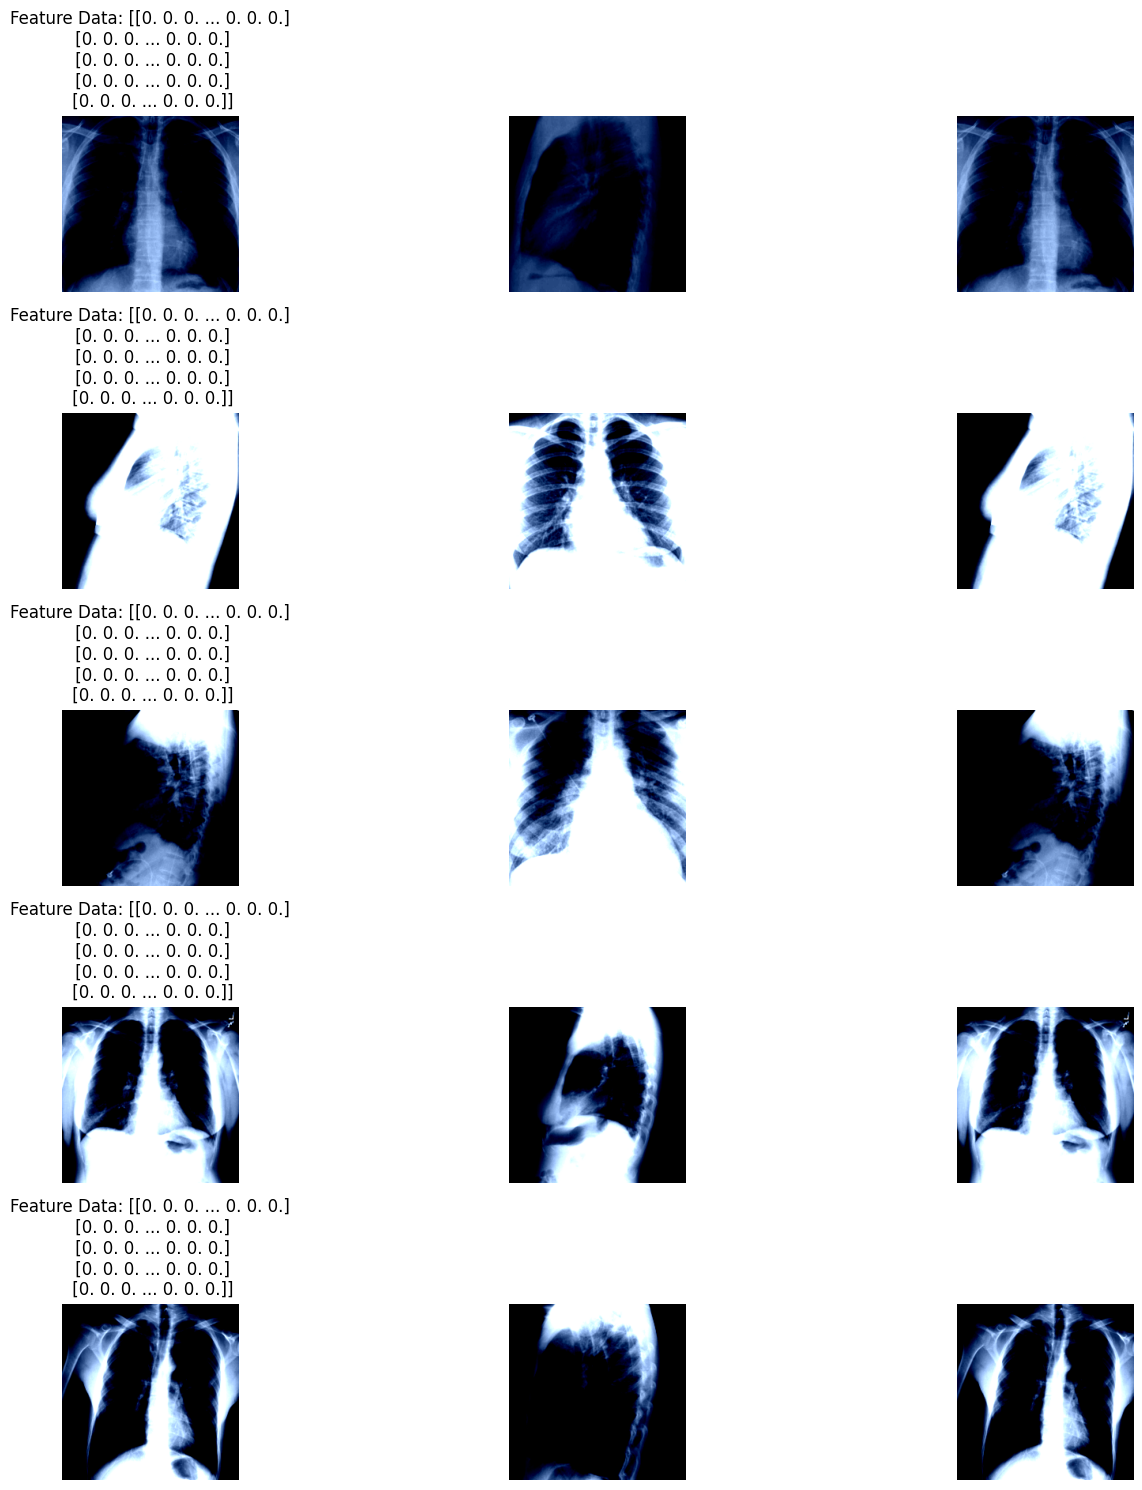

  0%|          | 0/414 [00:00<?, ?it/s]


In [33]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import os
from transformers import AutoTokenizer
from torchvision import transforms
import json
import matplotlib.pyplot as plt
from tqdm import tqdm

class XRayDataset(Dataset):
    def __init__(self, image_base_dir, feature_base_dir, report_data, tokenizer, transform=None):
        self.image_base_dir = image_base_dir  # Base directory containing images
        self.feature_base_dir = feature_base_dir  # Base directory containing .npy feature arrays
        self.report_data = report_data  # Loaded reports data
        self.tokenizer = tokenizer
        self.transform = transform
    
    def __len__(self):
        return len(self.report_data)  # Number of samples in the dataset

    def __getitem__(self, idx):
        # Get the current report and corresponding images
        report_item = self.report_data[idx]
        report = report_item['report']  # Extract report text
        image_paths = report_item['image_path']  # List of image paths for the sample
        report_id = report_item['id']  # Get the report ID to locate corresponding .npy file
        
        images = []
        feature_data = []
        
        # Loop through each image path in the 'image_path' list
        for image_path in image_paths:
            # Construct the full image path based on base directory
            full_image_path = os.path.join(self.image_base_dir, image_path)
            
            # Load the image
            image = Image.open(full_image_path).convert('RGB')
            
            # Apply transformations if defined
            if self.transform:
                image = self.transform(image)
            
            images.append(image)
        
        # Load the corresponding .npy feature array
        npy_file_path = os.path.join(self.feature_base_dir, f"{report_id}", "0.npy")  # Assuming '0.npy' for simplicity
        feature_array = np.load(npy_file_path)
        feature_data = torch.tensor(feature_array, dtype=torch.float32)  # Convert the numpy array to a tensor
        
        # Stack the images into a single tensor (shape: [3, C, H, W])
        images = torch.stack(images) if len(images) == 3 else torch.stack(images + [images[0]] * (3 - len(images)))
        
        # Tokenize the report
        encoded_report = self.tokenizer(report, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
        
        return images, feature_data, encoded_report

# Define the image base directory, feature base directory, and report JSON file path
image_base_dir = "/kaggle/input/iu-xraydataset/iu_xray/images"
feature_base_dir = "/kaggle/input/iu-xraydataset/iu_xray/images300_array"
json_file_path = "/kaggle/input/iu-xraydataset/iu_xray/annotation.json"

# Load the report data from the JSON file
with open(json_file_path, 'r') as f:
    data = json.load(f)

# Extract the list of reports (train split in this case)
train_reports = data['train']

# Set up DataLoader with transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize the tokenizer for BERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Create the dataset and DataLoader
dataset = XRayDataset(image_base_dir, feature_base_dir, train_reports, tokenizer, transform)
dataloader = DataLoader(dataset, batch_size=5, shuffle=True)

# Iterate through the dataloader for training or inspection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Display 5 samples with images and their corresponding feature data
for images, feature_data, reports in tqdm(dataloader):
    images = images.to(device)  # Move images to GPU if available
    feature_data = feature_data.to(device)  # Move feature data to GPU if available
    
    # Display images and corresponding data
    fig, axes = plt.subplots(5, 3, figsize=(15, 15))
    for i in range(5):  # Display 5 samples
        for j in range(3):  # Each sample has 3 images, even if some are repeated
            axes[i, j].imshow(images[i][j].cpu().numpy().transpose(1, 2, 0))
            axes[i, j].axis('off')
        axes[i, 0].set_title(f"Feature Data: {feature_data[i].cpu().numpy()[:5]}")  # Display the first few elements of the feature array for each sample
    
    plt.tight_layout()
    plt.show()
    
    # Here you would add the model's forward pass, loss calculation, etc.
    break  # Stop after displaying the first batch of 5 samples (you can remove this in training loop)


  0%|          | 0/414 [00:00<?, ?it/s]/tmp/ipykernel_23/507510262.py:110: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


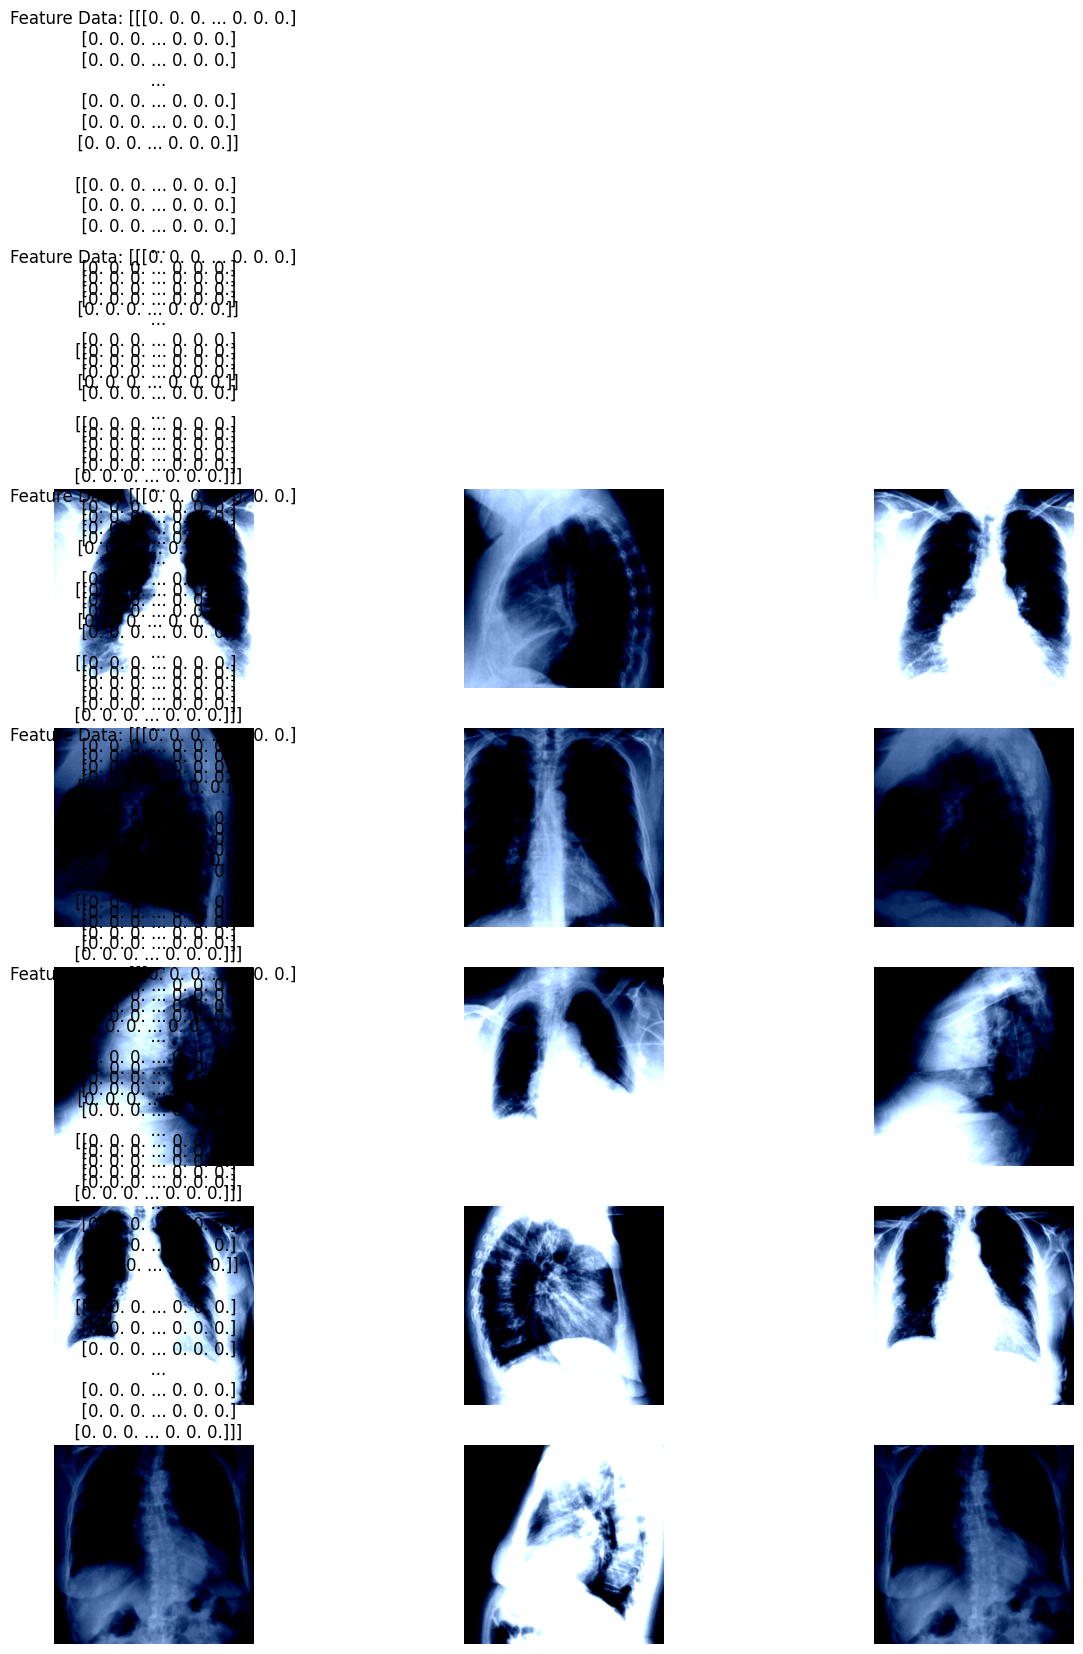

  0%|          | 0/414 [00:01<?, ?it/s]


In [34]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import os
from transformers import AutoTokenizer
from torchvision import transforms
import json
import matplotlib.pyplot as plt
from tqdm import tqdm

class XRayDataset(Dataset):
    def __init__(self, image_base_dir, feature_base_dir, report_data, tokenizer, transform=None):
        self.image_base_dir = image_base_dir  # Base directory containing images
        self.feature_base_dir = feature_base_dir  # Base directory containing .npy feature arrays
        self.report_data = report_data  # Loaded reports data
        self.tokenizer = tokenizer
        self.transform = transform
    
    def __len__(self):
        return len(self.report_data)  # Number of samples in the dataset

    def __getitem__(self, idx):
        # Get the current report and corresponding images
        report_item = self.report_data[idx]
        report = report_item['report']  # Extract report text
        image_paths = report_item['image_path']  # List of image paths for the sample
        report_id = report_item['id']  # Get the report ID to locate corresponding .npy file
        
        images = []
        feature_data = []
        
        # Loop through each image path in the 'image_path' list
        for i, image_path in enumerate(image_paths):
            # Construct the full image path based on base directory
            full_image_path = os.path.join(self.image_base_dir, image_path)
            
            # Load the image
            image = Image.open(full_image_path).convert('RGB')
            
            # Apply transformations if defined
            if self.transform:
                image = self.transform(image)
            
            images.append(image)
            
            # Construct the corresponding .npy feature file path for the current image (based on index)
            npy_file_path = os.path.join(self.feature_base_dir, f"{report_id}", f"{i}.npy")
            if os.path.exists(npy_file_path):  # Ensure the feature file exists
                feature_array = np.load(npy_file_path)
                feature_data.append(torch.tensor(feature_array, dtype=torch.float32))  # Convert the numpy array to a tensor
            else:
                # If the corresponding .npy file doesn't exist, we could handle it, e.g., by using a default value or skipping.
                feature_data.append(torch.zeros(1))  # Here we use a dummy feature if .npy file is missing
        
        # If there are fewer than 3 images, repeat the first image to fill the required number of images
        images = torch.stack(images) if len(images) == 3 else torch.stack(images + [images[0]] * (3 - len(images)))
        
        # Ensure the feature data corresponds to 3 items
        feature_data = torch.stack(feature_data) if len(feature_data) == 3 else torch.stack(feature_data + [feature_data[0]] * (3 - len(feature_data)))
        
        # Tokenize the report
        encoded_report = self.tokenizer(report, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
        
        return images, feature_data, encoded_report

# Define the image base directory, feature base directory, and report JSON file path
image_base_dir = "/kaggle/input/iu-xraydataset/iu_xray/images"
feature_base_dir = "/kaggle/input/iu-xraydataset/iu_xray/images300_array"
json_file_path = "/kaggle/input/iu-xraydataset/iu_xray/annotation.json"

# Load the report data from the JSON file
with open(json_file_path, 'r') as f:
    data = json.load(f)

# Extract the list of reports (train split in this case)
train_reports = data['train']

# Set up DataLoader with transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize the tokenizer for BERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Create the dataset and DataLoader
dataset = XRayDataset(image_base_dir, feature_base_dir, train_reports, tokenizer, transform)
dataloader = DataLoader(dataset, batch_size=5, shuffle=True)

# Iterate through the dataloader for training or inspection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Display 5 samples with images and their corresponding feature data
for images, feature_data, reports in tqdm(dataloader):
    images = images.to(device)  # Move images to GPU if available
    feature_data = feature_data.to(device)  # Move feature data to GPU if available
    
    # Display images and corresponding data
    fig, axes = plt.subplots(5, 3, figsize=(15, 15))
    for i in range(5):  # Display 5 samples
        for j in range(3):  # Each sample has 3 images, even if some are repeated
            axes[i, j].imshow(images[i][j].cpu().numpy().transpose(1, 2, 0))
            axes[i, j].axis('off')
        axes[i, 0].set_title(f"Feature Data: {feature_data[i].cpu().numpy()[:5]}")  # Display the first few elements of the feature array for each sample
    
    plt.tight_layout()
    plt.show()
    
    # Here you would add the model's forward pass, loss calculation, etc.
    break  # Stop after displaying the first batch of 5 samples (you can remove this in training loop)


In [35]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import os
from transformers import AutoTokenizer
from torchvision import transforms
import json
import matplotlib.pyplot as plt
from tqdm import tqdm

class XRayDataset(Dataset):
    def __init__(self, image_base_dir, feature_base_dir, report_data, tokenizer, transform=None):
        self.image_base_dir = image_base_dir  # Base directory containing images
        self.feature_base_dir = feature_base_dir  # Base directory containing .npy feature arrays
        self.report_data = report_data  # Loaded reports data
        self.tokenizer = tokenizer
        self.transform = transform
    
    def __len__(self):
        return len(self.report_data)  # Number of samples in the dataset

    def __getitem__(self, idx):
        # Get the current report and corresponding images
        report_item = self.report_data[idx]
        report = report_item['report']  # Extract report text
        image_paths = report_item['image_path']  # List of image paths for the sample
        report_id = report_item['id']  # Get the report ID to locate corresponding .npy file
        
        images = []
        feature_data = []
        
        # Loop through each image path in the 'image_path' list (for now we will only use the first image)
        for i, image_path in enumerate(image_paths[:1]):  # Use only the first image (one image)
            # Construct the full image path based on base directory
            full_image_path = os.path.join(self.image_base_dir, image_path)
            
            # Load the image
            image = Image.open(full_image_path).convert('RGB')
            
            # Apply transformations if defined
            if self.transform:
                image = self.transform(image)
            
            images.append(image)
            
            # Construct the corresponding .npy feature file path for the current image (based on index)
            npy_file_path = os.path.join(self.feature_base_dir, f"{report_id}", f"0.npy")  # Using 0.npy as an example
            if os.path.exists(npy_file_path):  # Ensure the feature file exists
                feature_array = np.load(npy_file_path)
                feature_data.append(torch.tensor(feature_array, dtype=torch.float32))  # Convert the numpy array to a tensor
            else:
                # If the corresponding .npy file doesn't exist, we could handle it, e.g., by using a default value or skipping.
                feature_data.append(torch.zeros(1))  # Here we use a dummy feature if .npy file is missing
        
        # Ensure we have only 1 image and 1 feature data point
        images = torch.stack(images)
        feature_data = torch.stack(feature_data)
        
        # Tokenize the report
        encoded_report = self.tokenizer(report, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
        
        return images, feature_data, encoded_report

# Define the image base directory, feature base directory, and report JSON file path
image_base_dir = "/kaggle/input/iu-xraydataset/iu_xray/images"
feature_base_dir = "/kaggle/input/iu-xraydataset/iu_xray/images300_array"
json_file_path = "/kaggle/input/iu-xraydataset/iu_xray/annotation.json"

# Load the report data from the JSON file
with open(json_file_path, 'r') as f:
    data = json.load(f)

# Extract the list of reports (train split in this case)
train_reports = data['train']

# Set up DataLoader with transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize the tokenizer for BERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Create the dataset and DataLoader
dataset = XRayDataset(image_base_dir, feature_base_dir, train_reports, tokenizer, transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Iterate through the dataloader for training or inspection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Display one sample with its image, feature data, and report
for images, feature_data, reports in tqdm(dataloader):
    images = images.to(device)  # Move images to GPU if available
    feature_data = feature_data.to(device)  # Move feature data to GPU if available
    
    # Get the corresponding report for this sample
    report = reports['input_ids'][0]  # Only one report in this batch
    report_text = tokenizer.decode(report, skip_special_tokens=True)  # Decode report text
    
    # Display the image and its feature data
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(images[0].cpu().numpy().transpose(1, 2, 0))  # Display the image
    ax.axis('off')
    
    # Display feature data and report text
    print(f"Report: {report_text}")
    print(f"Feature Data: {feature_data[0].cpu().numpy()[:5]}")  # Display the first few elements of the feature array
    
    plt.tight_layout()
    plt.show()
    
    break  # Stop after displaying the first sample (can be removed for full training loop)


  0%|          | 0/2069 [00:00<?, ?it/s]


TypeError: argument 'ids': 'list' object cannot be interpreted as an integer

In [37]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import json
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm

# Define the XRayDataset class for loading images and reports
class XRayDataset(Dataset):
    def __init__(self, image_base_dir, report_data, tokenizer, transform=None):
        self.image_base_dir = image_base_dir  # Base directory containing images
        self.report_data = report_data  # Loaded reports data
        self.tokenizer = tokenizer
        self.transform = transform
    
    def __len__(self):
        return len(self.report_data)  # Number of samples in the dataset

    def __getitem__(self, idx):
        # Get the current report and corresponding images
        report_item = self.report_data[idx]
        report = report_item['report']  # Extract report text
        image_paths = report_item['image_path']  # List of image paths for the sample
        
        images = []
        
        # Process the first image in the list for simplicity (you can loop over others if needed)
        image_path = image_paths[0]
        full_image_path = os.path.join(self.image_base_dir, image_path)
        
        # Load the image
        image = Image.open(full_image_path).convert('RGB')
        
        # Apply transformations if defined
        if self.transform:
            image = self.transform(image)
        
        images.append(image)
        
        # Tokenize the report text
        encoded_report = self.tokenizer(report, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
        
        return images[0], encoded_report

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Load the dataset from annotation.json
with open('/kaggle/input/iu-xraydataset/iu_xray/annotation.json', 'r') as f:
    data = json.load(f)

# Set up image transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the image base directory
image_base_dir = "/kaggle/input/iu-xraydataset/iu_xray/images"

# Create dataset and dataloader
dataset = XRayDataset(image_base_dir, data['train'], tokenizer, transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Initialize the ResNet model
resnet_model = models.resnet101(pretrained=True)
resnet_model.eval()

# Feature extraction from the image using ResNet
def extract_features(image):
    with torch.no_grad():
        image = image.unsqueeze(0)  # Add batch dimension
        features = resnet_model(image)  # Pass image through ResNet
    return features

# Report generation (using BERT for simplicity in this case)
def generate_report(image_features, tokenizer):
    # For simplicity, we are assuming a pretrained sequence-to-sequence model for text generation
    # In a real scenario, you can use T5, GPT-2, or similar models for report generation
    # Here we assume a mock generation just for illustration

    # Generate a dummy report (replace with real model inference if available)
    generated_report = "The heart size appears normal. No abnormalities detected in the lungs."
    
    # Tokenize the generated report
    encoded_report = tokenizer(generated_report, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
    
    return encoded_report

# Example BLEU score calculation
def calculate_bleu_score(reference_reports, generated_reports):
    return corpus_bleu(reference_reports, generated_reports)

# Iterate through the dataloader and generate reports
generated_reports = []
reference_reports = []

for images, encoded_report in tqdm(dataloader):
    images = images.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    
    # Extract image features using ResNet
    image_features = extract_features(images)
    
    # Generate report (dummy report in this example)
    generated_report = generate_report(image_features, tokenizer)
    
    # Decode the original and generated reports to compute BLEU score
    original_report = tokenizer.decode(encoded_report['input_ids'][0], skip_special_tokens=True)
    
    generated_reports.append([generated_report])
    reference_reports.append([original_report])
    
    # Display the original and generated reports
    print(f"Original Report: {original_report}")
    print(f"Generated Report: {generated_report}")
    print("=" * 50)

# Calculate BLEU score
bleu_score = calculate_bleu_score(reference_reports, generated_reports)
print(f"BLEU Score: {bleu_score}")


  0%|          | 0/2069 [00:00<?, ?it/s]


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 1, 3, 224, 224]